# Creating and processing the dataset

In [1]:
#Creating the dataset
from src.data.make_dataset import generate_synthetic_data, DataRequestInput
from datetime import date
start_date = date(2015, 1, 1)  # Year, Month, Day
end_date = date(2023, 12, 31)  # Year, Month, Day
data_request = DataRequestInput(start_date=start_date, end_date=end_date)
synthetic_data = generate_synthetic_data(data_request)

c:\Users\NajibS\.conda\envs\RAG_env\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2024-11-11 09:47:27,178 - ReinformentLearningForPlantOperation - INFO - synthetic data generated


c:\Users\NajibS\OneDrive - Process Integration Limited\DigitalBrain\ReinforcementLearning\SyntheticData\ReinforcementLearningPlantOperation\src\data\make_dataset.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=request.start_date, end = request.end_date, freq = 'H')


2024-11-11 09:47:28,340 - ReinformentLearningForPlantOperation - INFO - Data is saved locally at data/raw\synthetic_data.csv


In [2]:
# Preprocessing the dataset
from src.data.preprocess import preprocess_data, PreprocessConfig
preprocess_config = PreprocessConfig() # using the default set values!
train_data, val_data, test_data = preprocess_data(config=preprocess_config)

2024-11-11 09:47:29,440 - ReinformentLearningForPlantOperation - INFO - Finished uploading local data synthetic_data


c:\Users\NajibS\OneDrive - Process Integration Limited\DigitalBrain\ReinforcementLearning\SyntheticData\ReinforcementLearningPlantOperation\src\data\preprocess.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file, index_col=0, parse_dates=True)


2024-11-11 09:47:30,338 - ReinformentLearningForPlantOperation - INFO - Data preprocessing completed


# Creating the environment And training the agent

In [1]:
from src.training.Model_TrainTest import Model_train, ModelEvaluationConfig

actions_list={
    'main_turbine_output': [0, 500],
    'secondary_turbine_output': [0, 500],
    'current_fuel_mixture_ratio': [0, 1],
    'generator_excitation': [0, 1],
    'emissions_control_intensity': [0, 1],
}

internal_states_initialValue={
    'current_power_output': 0,
    'fuel_consumption_rate': 0,
    'emissions_levels': 0,
    'current_operating_costs': 0,
    'emissions_quota': 40000,
    'hours_main_turbine_since_maintenance': 0,
    'hours_secondary_turbine_since_maintenance': 0,
    'current_fuel_mixture_ratio': 0.5,
    'Initial_storage': 0
}

environment_variables={
    'Energy_storage_capacity': 15000,
    'Turbine_maintenance_time': 10,
    'Turbine_use_b4_maintenance': 100
}

Model_config =ModelEvaluationConfig(
    agent_possible_actions=actions_list,
    train_total_timesteps=350000,
    internalStates_InitialVal = internal_states_initialValue,
    environment_variables=environment_variables,
    test_timesteps=1000,
)

TheMatrix = Model_train(Model_config)

c:\Users\NajibS\.conda\envs\RAG_env\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5    |
|    iterations      | 1    |
|    time_elapsed    | 395  |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 5         |
|    iterations           | 2         |
|    time_elapsed         | 721       |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.09     |
|    explained_variance   | 5.96e-08  |
|    learning_rate        | 1e-05     |
|    loss                 | 6.64e+13  |
|    n_updates            | 10        |
|    policy_gradient_loss | -7.35e-08 |
|    std                  | 1         |
|    value_loss           | 1.55e+14  |
---------------------------------------
-------------

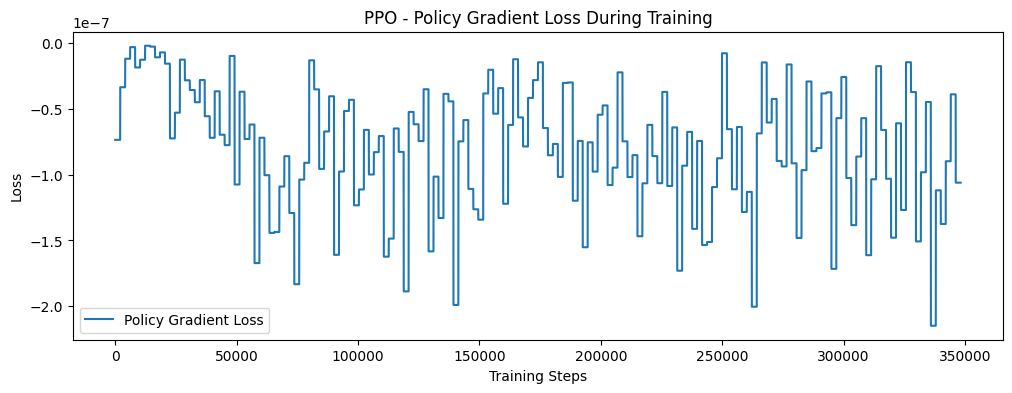

2024-11-12 19:56:14,102 - ReinformentLearningForPlantOperation - INFO - Finished training
Accumulative Reward at the end of 300 steps validation: -14675652.0
2024-11-12 19:56:39,271 - ReinformentLearningForPlantOperation - INFO - Accumulative Reward at the end of 300 steps validation: -14675652.0
2024-11-12 19:56:39,343 - ReinformentLearningForPlantOperation - INFO - Saved trained agent to src/training/saved_trained_models/PPOAgent_Steps_350000


In [2]:
# training the agent
train_environment, val_environment, agent, Reward, accumulative_reward = TheMatrix.train_agent()

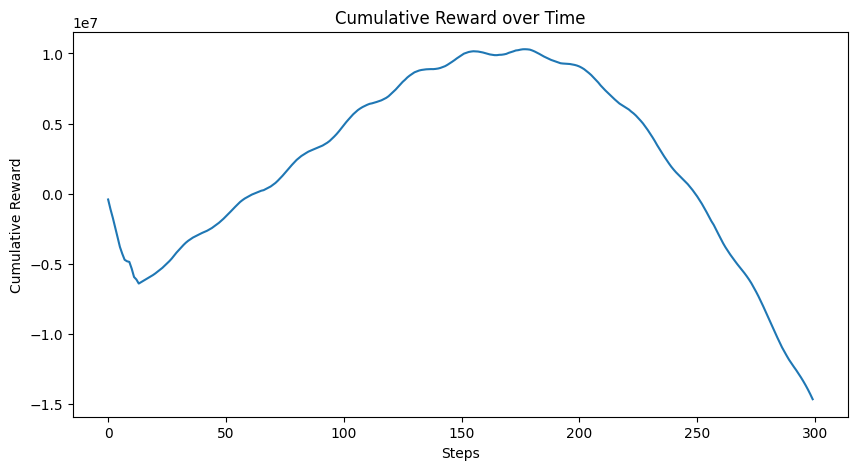

In [3]:
import matplotlib.pyplot as plt

def visualize_results(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Cumulative Reward over Time')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.show()

visualize_results(accumulative_reward)

# Testing

In [4]:
# from src.training.Model_TrainTest import Model_train, ModelEvaluationConfig


# Model_config =ModelEvaluationConfig(
#     agent_possible_actions=actions_list,
#     train_total_timesteps=500000,
#     internalStates_InitialVal = internal_states_initialValue,
#     environment_variables=environment_variables,
#     test_timesteps=2000,
# )

# TheMatrix = Model_train(Model_config)

test_accum_rewards, test_rewards, test_observation_space = TheMatrix.test_agent()


Using cpu device
model path src/training/saved_trained_models/PPOAgent_Steps_350000.zip


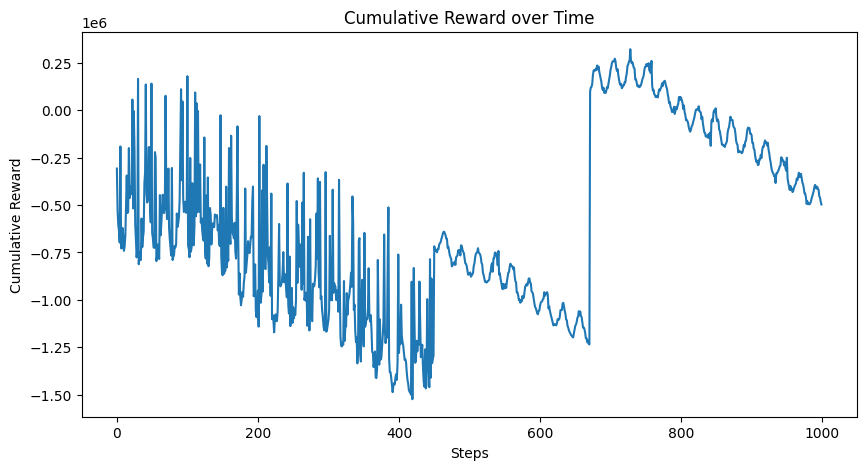

In [6]:
import matplotlib.pyplot as plt

def visualize_results(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Cumulative Reward over Time')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.show()

visualize_results(test_rewards)

In [16]:
import numpy as np
internal_state_variable =[]
variable_index = 18

for jj in range(len(test_observation_space)):
    step_observation = test_observation_space[jj]
    # print(step_observation.shape)
    internal_state_variable.append(step_observation[0,variable_index])
internal_state_variable = np.array(internal_state_variable)


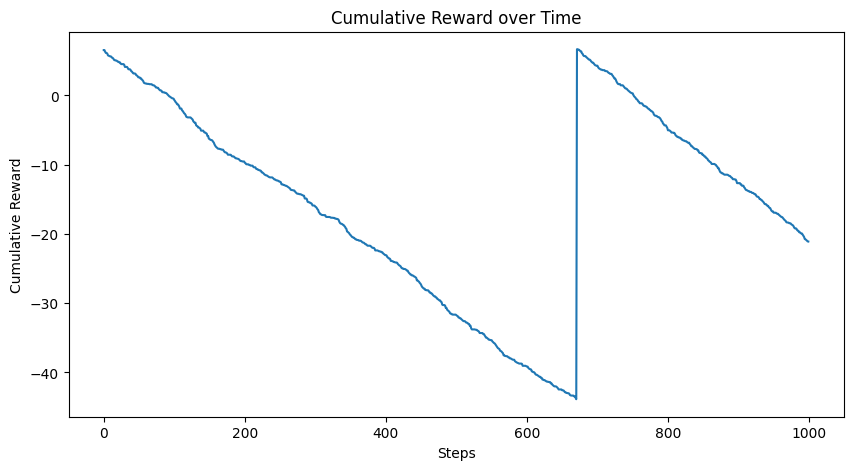

In [17]:
import matplotlib.pyplot as plt

def visualize_results(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Cumulative Reward over Time')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.show()

visualize_results(internal_state_variable)

In [21]:
# SAVING RESULTS
# INTERNAL STATES
import numpy as np
import pandas as pd
internal_states = []
for jj in range(len(test_observation_space)):
    observation_step = test_observation_space[jj]
    internal_states.append(observation_step[0,:])

variable_id_list = [f"Internal_variable_{ii}" for ii in range(len(observation_step[0,:]))]
internal_states_pd = pd.DataFrame(internal_states, columns=variable_id_list)

# REWARDS AND ACCUMMULATIVE REWARDS
combined_rewards = np.transpose(np.array([test_rewards, test_accum_rewards]))
rewards_pd = pd.DataFrame(combined_rewards, columns = ["rewards", "accum_rewards"])

complete_data = pd.concat([internal_states_pd, rewards_pd], axis=1)

file_name = "PPOAgent_350000Steps_results.csv"
complete_data.to_csv(file_name)


# Article plots

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go


file_path = "data/processed/train.csv" 
df = pd.read_csv(file_path)

columns_to_normalize = df.columns[df.columns.get_loc("index") + 1:]
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df = df.iloc[:50, :]

fig = go.Figure()

for col in columns_to_normalize:
    fig.add_trace(go.Scatter(x=df["index"], y=df[col], mode="lines", name=col))

# Update layout
fig.update_layout(
    title="Normalised Data  as a function of time",
    xaxis_title="time (hr)",
    yaxis_title="Normalized Value",
    width = 1000,
    height = 500,
)

fig.show()


In [22]:
# ACCUMMULATIVE REWARD
import plotly.graph_objects as go
trained_Agent = pd.read_csv("PPOAgent_350000Steps_results.csv")
initial_Agent = pd.read_csv("PPOAgent_10000Steps_results.csv")

# parameter to plot
parameter = "accum_rewards"

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = trained_Agent.index, y = trained_Agent[parameter],
    mode = "lines", name = "500k steps trained"))

fig.add_trace(go.Scatter(
    x = trained_Agent.index, y = initial_Agent[parameter],
    mode = "lines", name = "10k steps trained"))

fig.update_layout(
    yaxis_title = "Accummulated reward",
    xaxis_title = "time (hrs)",
    width = 800,
    height = 600,
    # yaxis=dict(range=[-1e8, 1e7]),
    # xaxis=dict(range=[0, 150])
    # yaxis_type = "log"
)
fig.show()

In [27]:
# OPERATIONAL PARAMETERS

# parameter to plot
parameter = "Internal_variable_18"

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = trained_Agent.index, y = trained_Agent[parameter],
    mode = "lines", name = "500k steps trained"))

fig.add_trace(go.Scatter(
    x = trained_Agent.index, y = initial_Agent[parameter],
    mode = "lines", name = "10k steps trained"))

fig.update_layout(
    yaxis_title = "Accummulated reward",
    xaxis_title = "time (hrs)",
    width = 800,
    height = 600,
    # yaxis_type = "log"
)
fig.show()

In [37]:
aa = 10000 % 24*28

In [38]:
aa

448